## Schrödinger Equation ##

We are going to solve the Schrodinger equation on a domain $\Omega_h$ with Dirichlet boundary contitions.

The equation to solve is:

$$
i \frac{\partial u}{\partial t} = \Delta u 
$$

Which we solve using, (Implicit Euler Method)

$$
i (u - u_n) = dt *  \Delta (u + u_n)/2
$$

As time integrator, here $u = u_{n+1}$. Since the eigenvalues of $\Delta$ are proportional to $\Delta x^2$, $\lambda = -c/\Delta x^2$, $c > 0$, we must be carefull with the stability region of the method. We have, for each eigenfunction, 

$$
(i - \lambda dt/2)u = (i + \lambda dt /2 )u_n
$$

Thus, the amplification factor is: 

$$
\left\|\frac{1 + i\lambda dt /2}{1 - i\lambda dt /2}\right\| = 1
$$

and the system is unconditionaly stable.



We shall use its weak form,

$$
\int [2i v*u +  \nabla v \cdot \nabla u ] \; d\Omega = \int [2i*v*u_n - \nabla v \cdot \nabla u_n ] \; d\Omega
$$



In [72]:
import Pkg; Pkg.activate("./gridap_makie"); # activamos el proyecto "gridap_makie" donde se intalarán todos los paquetes
using Gridap;
using GridapGmsh;
# using Gmsh;

# en caso de querer plotear dentro de Jupiter Notebook
#  debemos usar algunos paquetes. (no funciona en VSCode)
plot_s = false;
if plot_s
    using GridapMakie, GLMakie; #Para graficar 
    using FileIO;               #Gráficos y salidas
end

# crear directorios en caso de no haberlo hecho
create_directories = false;
if (create_directories==true)
    mkdir("models");
    mkdir("images");
end

  Activating project at `~/github_repositories/my_repositories/pde2022/tareas/07_tarea/gridap_makie`


In [73]:
#using GridapGeosciences
using Gridap.Arrays
#using Gridap.TensorValues
using Gridap.ReferenceFEs
#using Gridap.Geometry
#using Gridap.Fields
using Gridap.Algebra
using SparseArrays
using Gridap.FESpaces
using Gridap.CellData

In [74]:
l = 80;                  # cantidad de elementos por dimensión
domain = (0, 1, 0, 1);   # definimos el dominio dado por coordenadas
partition = (l, l);      # definimos grilla
model = CartesianDiscreteModel(domain, partition)
# dynamic viscosity

test = false;
bump = false;
particle = true;

save_file::String = "./results/QM/"

if test
    T = 1 / π
    num_steps = 1000
    n_int = 100
    save_file = save_file * "test" #where to save things
elseif bump
    save_file = save_file * "bump"
    T = 4
    num_steps = 1601
    n_int = 160
elseif particle
    save_file = save_file * "particle"
    T = 3           # final time for test

    num_steps = 1601   # number of time steps for 128 T=3 
    #num_steps = 12000   # number of time steps for 128 T=6 
    #num_steps = 10000   # number of time steps for 64 T=3 
    #num_steps = 50000   # number of time steps for 64 T=6 
        # Intervals where data is saved
    n_int = 160 # for 64
    #mod = 60 # for 128
    #mod = 120 # for 128 T=6
    #mod = 240 # for 256 T=3
    #mod = 480
end

dt / dx^2 = 12.0   dt / dx = 0.15  dt^3 / dx^6 = 1728.0


In [ ]:
dt = T / (num_steps - 1)
println("dt / dx^2 = $(dt * l^2)   dt / dx = $(dt * l)  dt^3 / dx^6 = $((dt * l^2)^3)")

+ El factor $\frac {dt}{dx^2}$ nos permite corroborar que, si es pequeño $ \lt 1$, el método de Euler usual funcionaría.
+ El factor $\frac {dt}{dx}$ si es aproximadamente 1 y no usamos métodos implícitos el método sería intestable.
+ EL factor $\frac {dt^3}{dx^6}$ nos dice cómo escala el error del método

The first number indicates what it would be the CFL condition for the explicit Euler method. The second a guide about taking time and space comparable steps. The third is proportinal to the error, obtained by expanding 

$$
\frac{1 + i\lambda dt /2}{1 - i\lambda dt /2} - e^{i\lambda dt} = (1 + i\lambda dt /2)(1 + i\lambda dt /2 - \frac{\lambda^2 dt^2}{4})  - (1 + i\lambda dt - \frac{\lambda^2 dt^2}{2}) = O(\lambda dt)^3 
$$

In [75]:
labels = get_face_labeling(model)
add_tag_from_tags!(labels, "diri_all", [1, 2, 3, 4, 5, 6, 7, 8]);

In [76]:
order = 2
degree = order
Ωₕ = Triangulation(model)
dΩₕ = Measure(Ωₕ, degree)

Measure()

In [77]:
ue(x) = x[1];
Γ₁ = BoundaryTriangulation(model, tags=[5, 6, 7, 8]);

In [78]:
if plot_s
    fig, ax, plt = plot(Γ₁, ue, colormap=:heat, linewidth=10)
    ax.aspect = AxisAspect(1)
    Colorbar(fig[1, 2], plt)
    fig
end

In [79]:
# scatter(BoundaryTriangulation(model,tags=[4]))

In [80]:
reffe = ReferenceFE(lagrangian, Float64, order);

In [81]:
V = TestFESpace(model, reffe, labels=labels, dirichlet_tags=["diri_all"], conformity=:H1, vector_type=Vector{ComplexF64});
U = TrialFESpace(V, 0.0);

Notemos que si bien el espacio de referencias (reffe) es de tipo Float64 el espacio de pruebas (V) es de tipo ComplexF64.

In [82]:
#ls = LUSolver()
#solver = LinearFESolver(ls)

In [83]:
norm_L2(u) = sqrt(real(sum(∫(u' * u) * dΩₕ)))

norm_L2 (generic function with 1 method)

In [84]:
function u_0_bump(x, par)
    r0, r1, p = par
    r = sqrt((x[1] - 0.5)^2 + (x[2] - 0.5)^2)
    if r > r0 && r < r1
        return (r - r0)^p * (r - r1)^p * (4^(2p)) + 0.0 * im
    else
        return 0.0 + 0.0 * im
    end
end

function u_0_particle(x, par)
    r0, xi, k, p = par
    r = sqrt((x[1] - xi[1])^2 + (x[2] - xi[2])^2)
    kx = 2π * (k[1] * (x[1] - xi[1]) + k[2] * (x[2] - xi[2]))
    if r < r0
        return (r - r0)^p * (r - r0)^p * (4^(2p)) * exp(im * kx)
    else
        return 0.0 + 0.0 * im
    end
end

function u_0_test(x, p)
    n, m = p
    return sin(π * x[1] * n) * sin(π * x[2] * m)
end

function test_solution(x, t, p)
    n, m = p
    ω = π^2 * (n^2 + m^2)
    return sin(π * x[1] * n) * sin(π * x[2] * m) * exp(im * ω * t)
end

par_bump = (0.25, 0.75, 4)
par_test = (2, 3)
par_particle = (0.4, [0.25; 0.25], [-16; 16], 4)

#u_0_bump([0.5;0.5], par_bump)
u_0_test([0.8; 0.5], par_test)
#u_0_particle([0.5;0.5], par_particle)


0.9510565162951536

In [85]:
# definimos funciones que serán las condiciones iniciales
if test
    u_0(x) = u_0_test(x, par_test)
elseif bump
    u_0(x) = u_0_bump(x, par_bump)
elseif particle
    u_0(x) = u_0_particle(x, par_particle)
end

u_n = interpolate_everywhere(u_0, V)
writevtk( Ωₕ,"./results/QM/ini_dat_$(lpad(0,3,'0'))", cellfields=["uh_r"=>real(u_n),"uh_i"=>imag(u_n)])

norm_L2(u_n)

2.4389232812125434

In [86]:
if plot_s
    fig, axₕlt = plot(Ωₕ, real(u_n))
    ax.aspect = AxisAspect(1)
    Colorbar(fig[2, 1], plt, vertical=false)
    current_figure()
    #fig
end

To generate just once the matrix A we follow this example: https://github.com/gridap/Gridap.jl/blob/master/test/FESpacesTests/AssemblersTests.jl



In [ ]:
assem=SparseMatrixAssembler(U,V);           # ensamblamos una matriz sparse con U y V
dv=get_fe_basis(V);                         # escribimos v en la base de FE de V            
du=get_trial_fe_basis(U);                   # escribimos u en la base de FE de U

a(u,v)=∫(∇(v)⋅∇(u)*dt+im*2.0*v*u)dΩₕ;       # definimos forma bilineal

mat_contribs=a(du,dv);                      # creamos una matriz de bases (contribuciones)
data=collect_cell_matrix(U,V,mat_contribs); # recolectamos una matriz (datos)
A=assemble_matrix(assem,data);              # creamos matriz A con contribuciones y datos

In [87]:
t=0;  # inicializamos variable tiempo
u_n = interpolate_everywhere(u_0, V)
writevtk(
  Ωₕ, save_file * "_$(lpad(0,3,'0'))",
  cellfields=["uh_r" => real(u_n), "uh_i" => imag(u_n)])


if test
  e = zeros(num_steps ÷ n_int)
end

for istep in 1:num_steps

  #println("\n+++ Solving in step $istep of $num_steps +++\n")
  b(v) = ∫(∇(v) ⋅ ∇(-u_n) * dt + im * 2 * v * u_n)dΩₕ
  vec_contribs = b(dv)
  data = collect_cell_vector(V, vec_contribs)
  b = assemble_vector(assem, data)

  #op = AffineFEOperator(a,b,U,V)
  #uh = solve(solver,op)
  x = A \ b
  t = t + dt
  uh = FEFunction(U, x)

  u_n = uh

  if (istep - 1) % n_int == 0 && istep > 1
    writevtk(
      Ωₕ, save_file * "_$(lpad(istep,3,'0'))",
      cellfields=["uh_r" => real(u_n), "uh_i" => imag(u_n)])
    if test
      u_0(x) = test_solution(x, t, par_test)
      u_s = interpolate_everywhere(u_0, V)
      writevtk(
        Ωₕ, save_file * "_error_$(lpad(istep,3,'0'))",
        cellfields=["error_r" => real(u_n - u_s), "error_i" => imag(u_n - u_s)])
      error = norm_L2(u_n - u_s)
      e[(istep-1)÷n_int] = error
      l2 = norm_L2(u_n)
      println("time = $t, rel_error = $(error/l2),      l2 = $l2")
    end
  end

end


Vemos que el error tiene un crecimiento lineal, tal como se espera. 

In [88]:
if test
    scatter(e)
end

### Analizamos cómo se comporta el error

In [89]:
f(μ) = (1-μ/2)/(1+μ/2) - exp(-μ)

f (generic function with 1 method)

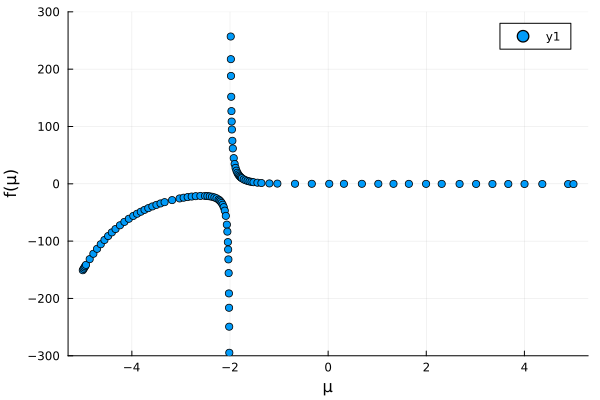

In [90]:
using Plots
scatter(f, xlabel="μ", ylabel="f(μ)", ylims=(-300,300))

<!-- useful links: https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video -->

### Parte imaginaría función test
<video controls width="500">
  <!-- <source src="./results/QM/movie.webm" type="video/webm" /> -->
  <source src="./results/QM/test_imaginarypart_movie.mp4" type="video/mp4"/>
  <!-- <p>
    Your browser doesn't support HTML video. Here is a
    <a href="./results/QM/movie.mp4">link to the video</a> instead.
  </p> -->
</video>

### Función densidad partícula
<video controls width="500">
  <source src="./results/QM/particle_density_movie.mp4" type="video/mp4"/>
</video>